<a href="https://colab.research.google.com/github/UmarIgan/Machine-Learning/blob/master/Quantum_Method_for_Portfolio_Optimizationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the libraries

- Quantum computing for porfolio optimization

In [78]:
!pip install qiskit-finance
!pip install riskfolio-lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**- Import Libraries**

Import necessary packages:

In [79]:
%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import YahooDataProvider
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit import Aer, execute
from qiskit.algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit.opflow import PauliExpectation, CVaRExpectation
import datetime, matplotlib.pyplot as plt, numpy as np

Retrieve stock data from Yahoo Finance API:

> Indented block



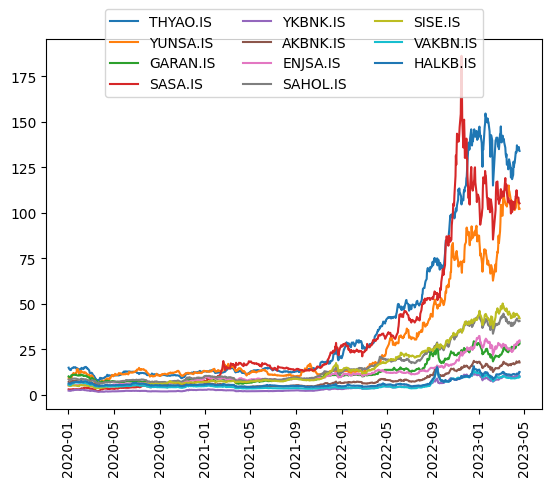

In [80]:
stocks = ["THYAO.IS", "YUNSA.IS", "GARAN.IS", "SASA.IS", "YKBNK.IS", "AKBNK.IS", "ENJSA.IS","SAHOL.IS", "SISE.IS", "VAKBN.IS", "HALKB.IS"]
try:
    data = YahooDataProvider(
                 tickers = stocks,
                 start=datetime.datetime(2020, 1, 1),
                 end=datetime.datetime(2023, 4, 22))
    
    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex: 
    data = None
    print(ex)

In [81]:
def return_qb(data):
    mu = data.get_period_return_mean_vector()
    sigma = data.get_period_return_covariance_matrix()
    q = 0.5                   # set risk factor
    budget = 1  # set budget
    penalty = len(stocks)      # set parameter to scale the budget penalty term

    portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
    qp = portfolio.to_quadratic_program()
    return qp
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    total_weight = sum(selection)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    print('\n----------------- Asset weights ---------------------')
    for i in range(len(stocks)):
        if selection[i] > 0.5:
            weight = selection[i] / total_weight
            print('{}: {:.4f}'.format(stocks[i], weight))

start_time = time.time()


qp = return_qb(data)
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qp)
end_time = time.time()
print("Time taken for quantum method: ", end_time - start_time, "seconds") 

Time taken for quantum method:  0.3290722370147705 seconds


- probability of each possible selection of assets based on the solution vector obtained from the optimization algorithm

In [82]:
dict(zip(stocks, list(result)))

{'THYAO.IS': 0.0,
 'YUNSA.IS': 0.0,
 'GARAN.IS': 0.0,
 'SASA.IS': 1.0,
 'YKBNK.IS': 0.0,
 'AKBNK.IS': 0.0,
 'ENJSA.IS': 0.0,
 'SAHOL.IS': 0.0,
 'SISE.IS': 0.0,
 'VAKBN.IS': 0.0,
 'HALKB.IS': 0.0}

- Using classical method 

In [83]:
import riskfolio as rp
import yfinance as yf
import pandas as pd

In [84]:
data_yf = yf.download(tickers=stocks, 
                      start=datetime.datetime(2020, 1, 1),
                 end=datetime.datetime(2023, 4, 22))
close_data = pd.DataFrame(data_yf['Close'])
close_data.columns = stocks
close_data.head()

[*********************100%***********************]  11 of 11 completed


,THYAO.IS,YUNSA.IS,GARAN.IS,SASA.IS,YKBNK.IS,AKBNK.IS,ENJSA.IS,SAHOL.IS,SISE.IS,VAKBN.IS,HALKB.IS
Date,,,,,,,,,,,
2020-01-02,8.18,7.56,11.26,6.13,9.88,2.923528,5.33,14.83,5.56,2.52,10.57
2020-01-03,7.96,7.31,10.95,6.02,9.64,2.875358,5.27,14.27,5.37,2.45,10.20
2020-01-06,7.71,7.13,10.60,6.03,9.41,2.790135,5.12,13.57,5.16,2.40,9.83
2020-01-07,7.79,7.27,10.59,6.03,9.45,2.853126,5.12,13.54,5.25,2.40,9.95
2020-01-08,7.96,7.31,11.08,6.10,9.63,2.797545,5.09,13.50,5.36,2.42,9.70


In [85]:
import riskfolio as rp
def hierarchical_risk_parity(Y):
    port = rp.HCPortfolio(returns=Y)

    # Estimate optimal portfolio:

    model = 'HRP'  # Could be HRP or HERC
    codependence = 'pearson'  # Correlation matrix used to group static in clusters
    rm = 'MV'  # Risk measure used, this time will be variance
    rf = 0  # Risk free rate
    linkage = 'single'  # Linkage method used to build clusters
    max_k = 10  # Max number of clusters used in two difference gap statistic
    leaf_order = True  # Consider optimal order of leafs in dendrogram

    w = port.optimization(model=model,codependence=codependence,rm=rm,rf=rf,linkage=linkage,max_k=max_k,leaf_order=leaf_order)
    return w

def black_litterman(Y):
    port = rp.Portfolio(returns=Y)
    # Estimate optimal portfolio:
    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.
    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    # Estimate optimal portfolio:

    model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    rm = 'EDaR' # Risk measure used, this time will be variance
    obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    l = 0 # Risk aversion factor, only useful when obj is 'Utility'
    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    return w

def hierarchical_equal_risk_contribution(Y):
    port = rp.HCPortfolio(returns=Y)
    # Estimate optimal portfolio:

    model = 'HERC'  # Could be HRP or HERC
    codependence = 'pearson'  # Correlation matrix used to group static in clusters
    rm = 'MV'  # Risk measure used, this time will be variance
    rf = 0  # Risk free rate
    linkage = 'ward'  # Linkage method used to build clusters
    max_k = 10  # Max number of clusters used in two difference gap statistic
    leaf_order = True  # Consider optimal order of leafs in dendrogram

    w = port.optimization(model=model,codependence=codependence,rm=rm,rf=rf,linkage=linkage,max_k=max_k,leaf_order=leaf_order).T

    data2 = w.T.reset_index()
    data2.columns = ['symbol', 'hierarchical equal risk contribution']

    return data2

In [86]:
import time

start_time = time.time()
result1 = hierarchical_risk_parity(close_data)
end_time = time.time()

print("Time taken for hierarchical_risk_parity: ", end_time - start_time, "seconds")
print(result1)

Time taken for hierarchical_risk_parity:  0.08768820762634277 seconds
           weights
THYAO.IS  0.075655
YUNSA.IS  0.033677
GARAN.IS  0.042885
SASA.IS   0.328657
YKBNK.IS  0.009502
AKBNK.IS  0.000682
ENJSA.IS  0.016170
SAHOL.IS  0.000655
SISE.IS   0.332015
VAKBN.IS  0.158738
HALKB.IS  0.001366


In [87]:
start_time = time.time()
result2 = black_litterman(close_data)
end_time = time.time()

print("Time taken for black_litterman: ", end_time - start_time, "seconds")
print(result2)

Time taken for black_litterman:  0.209367036819458 seconds
           weights
THYAO.IS  0.012292
YUNSA.IS  0.005744
GARAN.IS  0.004495
SASA.IS   0.023140
YKBNK.IS  0.004342
AKBNK.IS  0.218107
ENJSA.IS  0.013451
SAHOL.IS  0.697816
SISE.IS   0.009953
VAKBN.IS  0.007129
HALKB.IS  0.003532


In [88]:
start_time = time.time()
result3 = hierarchical_equal_risk_contribution(close_data).set_index('symbol')
end_time = time.time()
print("Time taken for hierarchical_equal_risk_contribution: ", end_time - start_time, "seconds")
print(result3)

Time taken for hierarchical_equal_risk_contribution:  0.14191269874572754 seconds
          hierarchical equal risk contribution
symbol                                        
THYAO.IS                          1.457838e-03
YUNSA.IS                          3.452973e-05
GARAN.IS                          5.798792e-04
SASA.IS                           4.948897e-01
YKBNK.IS                          1.447931e-05
AKBNK.IS                          2.043205e-06
ENJSA.IS                          1.138816e-05
SAHOL.IS                          9.980930e-07
SISE.IS                           4.999462e-01
VAKBN.IS                          3.058813e-03
HALKB.IS                          4.095768e-06
